## Introduction

Capital Bikeshare is a bike-sharing program in the Washington D.C. metropolitan area. It allows users to rent a bike from one of the many stations located throughout the city and surrounding suburbs. The program was launched in 2010. It is a popular transportation option for both locals and tourists, as it provides a convenient and affordable way to get around the area, and also solves the matters of parking and traffic. The program has also helped to promote cycling as a healthy and sustainable mode of transportation.

### Business situation

Capital Bikeshare, with over 5,000 bikes and 600 stations in the Washington metropolitan area, faces a challenge of ensuring that bikes are properly maintained and accessible to users. The number of users can vary daily, making accurate predictions critical to adjust operations in a cost-effective and efficient way. To achieve this, Capital Bikeshare needs to monitor and analyze bike and dock availability at each station and rebalance bikes to prevent over or understocking. For instance, by predicting the number of pickups and drop-offs at stations such as 21st & I St NW and 21st St & Pennsylvania Ave NW, Capital Bikeshare can use the final model's results to determine how many bicycles to deploy to each station.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 

### Data collection

The dataset we use is partially from [Capital Bikeshare system data](https://ride.capitalbikeshare.com/system-data), specifically taking the period from January to April 2022. Another part is [weather data](https://www.visualcrossing.com/weather-history/washington,%20dc/us/2022-01-01/2022-12-31) of Washington, D.C in 2022. One factor we would consider is the university’s calendar which might impact the usage of this service.The reason is that two stations experimented here are nearby The George Washington University. Therefore, in our model, we decide to put this data into the overall dataset. Particularly, day off could be no-class days based on the university's calendar (https://www.gwu.edu/academic-calendar) or weekend days (Saturday and Sunday).

### Capital Bikeshare Data
https://ride.capitalbikeshare.com/system-data

We deal with data from Jan to Apr in 2022

In [2]:
# read csv files
df_Jan=pd.read_csv('202201-capitalbikeshare-tripdata.csv')
df_Feb=pd.read_csv('202202-capitalbikeshare-tripdata.csv')
df_Mar=pd.read_csv('202203-capitalbikeshare-tripdata.csv')
df_Apr=pd.read_csv('202204-capitalbikeshare-tripdata.csv')

In [3]:
# concat data
df=pd.concat([df_Jan,df_Feb,df_Mar,df_Apr])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828621 entries, 0 to 310434
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             828621 non-null  object 
 1   rideable_type       828621 non-null  object 
 2   started_at          828621 non-null  object 
 3   ended_at            828621 non-null  object 
 4   start_station_name  792027 non-null  object 
 5   start_station_id    792027 non-null  float64
 6   end_station_name    786251 non-null  object 
 7   end_station_id      786251 non-null  float64
 8   start_lat           828621 non-null  float64
 9   start_lng           828621 non-null  float64
 10  end_lat             827170 non-null  float64
 11  end_lng             827170 non-null  float64
 12  member_casual       828621 non-null  object 
dtypes: float64(6), object(7)
memory usage: 88.5+ MB


In [4]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member


### Now I extract information of date for further analysis

In [5]:
# Transform timestamp to date format only
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,started_at_date,ended_at_date
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member,2022-01-06,2022-01-06
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member,2022-01-31,2022-01-31
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member,2022-01-07,2022-01-07
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual,2022-01-27,2022-01-27
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member,2022-01-07,2022-01-07


### In this project, we will work with '21st & I St NW' and '21st St & Pennsylvania Ave NW' stations.

### First, we start with '21st & I St NW' station.

### Count daily pickups

In [7]:
# Group and get pickup occurrence for 21st & I St NW
df_sub1 = df[df['start_station_name']=="21st & I St NW"]
df_grp1 = df_sub1.groupby(['started_at_date','start_station_name']).size()
df_pu1=df_grp1.reset_index(name = "pu_ct_1")
df_pu1

,started_at_date,start_station_name,pu_ct_1
0,2022-01-01,21st & I St NW,7
1,2022-01-02,21st & I St NW,5
2,2022-01-04,21st & I St NW,2
3,2022-01-05,21st & I St NW,5
4,2022-01-06,21st & I St NW,10
...,...,...,...
113,2022-04-26,21st & I St NW,49
114,2022-04-27,21st & I St NW,67
115,2022-04-28,21st & I St NW,58
116,2022-04-29,21st & I St NW,69


### Count daily dropoffs

In [8]:
# Group and get drop off occurrence for 21st & I St NW
df_sub2 = df[df['end_station_name']=="21st & I St NW"]
df_grp2 = df_sub2.groupby(['ended_at_date','end_station_name']).size()
df_do1=df_grp2.reset_index(name = "do_ct_1")
df_do1

,ended_at_date,end_station_name,do_ct_1
0,2022-01-01,21st & I St NW,5
1,2022-01-02,21st & I St NW,5
2,2022-01-04,21st & I St NW,6
3,2022-01-05,21st & I St NW,5
4,2022-01-06,21st & I St NW,10
...,...,...,...
113,2022-04-26,21st & I St NW,67
114,2022-04-27,21st & I St NW,53
115,2022-04-28,21st & I St NW,57
116,2022-04-29,21st & I St NW,63


### Visualize pickups and dropoffs

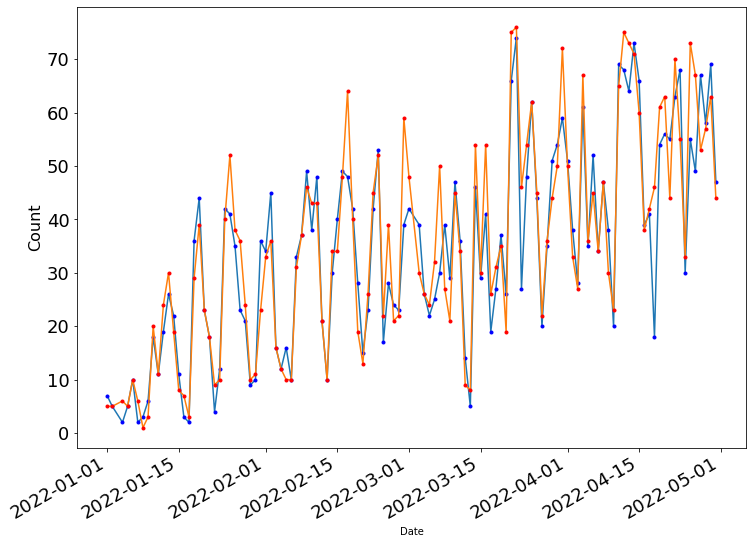

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( df_pu1['started_at_date'], df_pu1['pu_ct_1'],linestyle = 'solid',markeredgecolor = 'blue',markerfacecolor = 'blue', markersize = 3)
ax1.plot_date( df_do1['ended_at_date'], df_do1['do_ct_1'],linestyle = 'solid',markeredgecolor = 'red',markerfacecolor = 'red', markersize = 3)

ax1.set_xlabel('Date',fontsize=10)
ax1.set_ylabel('Count',fontsize=16)
plt.gcf().autofmt_xdate()

plt.tick_params(labelsize=18)
plt.show()  

## Weather Data

In [10]:
df_weather = pd.read_csv('DC Weather 2022-01-01 to 2022-12-31.csv')

df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Washington,DC,USA",2022-01-01,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,...,0.6,0,NaN,2022-01-01T07:26:53,2022-01-01T16:56:53,0.99,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
1,"Washington,DC,USA",2022-01-02,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,...,1.7,1,NaN,2022-01-02T07:27:00,2022-01-02T16:57:43,1.00,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."
2,"Washington,DC,USA",2022-01-03,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,...,0.0,0,NaN,2022-01-03T07:27:05,2022-01-03T16:58:34,0.00,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,snow,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
3,"Washington,DC,USA",2022-01-04,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,...,5.4,6,NaN,2022-01-04T07:27:07,2022-01-04T16:59:27,0.02,Clear,Clear conditions throughout the day.,snow,"KDCA,72405013743,72403793728,D6279,F0198,KADW,..."
4,"Washington,DC,USA",2022-01-05,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,...,2.2,1,NaN,2022-01-05T07:27:08,2022-01-05T17:00:21,0.05,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."


## Check missing values

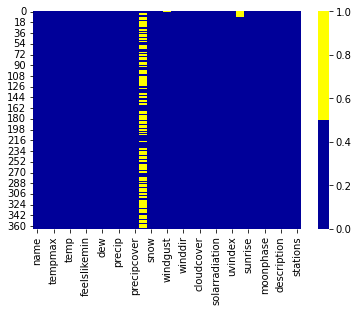

In [11]:
# Date time format 
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date

# Use sns heatmap to see whats are the null values.
coln = df_weather.columns[:df_weather.shape[1]]  
colors = ['#000099','#ffff00'] # specify the colors - yellow is missing. blue is not missing.
sns.heatmap(df_weather[coln].isnull(), cmap = sns.color_palette(colors))
plt.show()

## Calendar data

One factor we would consider is the university’s calendar which might impact the usage of this service. The reason is that two stations experimented here are nearby The George Washington University. Therefore, in our model, we decide to put this data into the overall dataset. Particularly, day off could be no-class days based on the university's calendar (https://www.gwu.edu/academic-calendar) or weekend days (Saturday and Sunday). Furthermore, we denote the dayoff is 1 and non_dayoff is 0. Weekend columns also have two values. The weekend days are 0, and others are 0. We do this to make it easier to train and test the models.

In [12]:
# read calendar csv file
calendar=pd.read_csv('Calendar.csv')

In [13]:
calendar.head()

,date,Day in week,Day off,Weekend
0,01/01/2022,Saturday,1,1
1,01/02/2022,Sunday,1,1
2,01/03/2022,Monday,1,0
3,01/04/2022,Tuesday,1,0
4,01/05/2022,Wednesday,1,0


In [14]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         365 non-null    object
 1   Day in week  365 non-null    object
 2   Day off      365 non-null    int64 
 3   Weekend      365 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.5+ KB


In [15]:
calendar['date']= pd.to_datetime(calendar['date']).dt.date

## Drop variables before running models

In [16]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])
calendar=calendar.drop(columns=['Day in week'])

## Prepare X and y: Merge weather data with trip data

In [17]:
# Merge with weather data, calendar data, and remove dates and station name
df_m_pu1 = df_pu1.merge(df_weather, left_on='started_at_date', right_on='datetime') 
df_m_pu1 = df_m_pu1.merge(calendar, left_on='datetime', right_on='date') 
df_m_pu1 = df_m_pu1.drop(columns=['started_at_date','start_station_name','datetime','date'])

In [18]:
df_m_do1 = df_do1.merge(df_weather, left_on='ended_at_date', right_on='datetime') 
df_m_do1 = df_m_do1.merge(calendar, left_on='ended_at_date', right_on='date') 
df_m_do1 = df_m_do1.drop(columns=['ended_at_date','end_station_name','datetime','date'])

In [19]:
df_m_pu1.head()

,pu_ct_1,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon,Day off,Weekend
0,7,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,...,1007.2,99.5,6.2,21.4,0.6,0,0.99,rain,1,1
1,5,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,...,1006.6,91.6,9.6,47.3,1.7,1,1.00,rain,1,1
2,2,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,...,1029.7,18.7,9.9,153.2,5.4,6,0.02,snow,1,0
3,5,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,...,1014.5,82.6,9.9,63.5,2.2,1,0.05,partly-cloudy-day,1,0
4,10,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,...,1012.7,88.1,9.9,145.6,5.3,4,0.09,snow,1,0


In [20]:
df_m_do1.head()

,do_ct_1,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon,Day off,Weekend
0,5,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,...,1007.2,99.5,6.2,21.4,0.6,0,0.99,rain,1,1
1,5,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,...,1006.6,91.6,9.6,47.3,1.7,1,1.00,rain,1,1
2,6,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,...,1029.7,18.7,9.9,153.2,5.4,6,0.02,snow,1,0
3,5,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,...,1014.5,82.6,9.9,63.5,2.2,1,0.05,partly-cloudy-day,1,0
4,10,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,...,1012.7,88.1,9.9,145.6,5.3,4,0.09,snow,1,0


## Train linear models

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [22]:
# pickup
y1_pu = df_m_pu1['pu_ct_1']
X1_pu = df_m_pu1.drop('pu_ct_1',axis=1)
X1_pu = pd.get_dummies(data=X1_pu, drop_first=True)
X1_pu.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,solarradiation,solarenergy,uvindex,moonphase,Day off,Weekend,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
0,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,100,...,21.4,0.6,0,0.99,1,1,0,1,0,0
1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,100,...,47.3,1.7,1,1.00,1,1,0,1,0,0
2,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,0,...,153.2,5.4,6,0.02,1,0,0,0,1,0
3,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,0,...,63.5,2.2,1,0.05,1,0,1,0,0,0
4,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,0,...,145.6,5.3,4,0.09,1,0,0,0,1,0


In [23]:
X1_pu_train,X1_pu_test, y1_pu_train,y1_pu_test = train_test_split(X1_pu,y1_pu, test_size=0.4, random_state = 200)

In [24]:
# dropoff
y1_do = df_m_do1['do_ct_1']
X1_do = df_m_do1.drop('do_ct_1',axis=1)
X1_do = pd.get_dummies(data=X1_do, drop_first=True)
X1_do.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,solarradiation,solarenergy,uvindex,moonphase,Day off,Weekend,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
0,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,100,...,21.4,0.6,0,0.99,1,1,0,1,0,0
1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,100,...,47.3,1.7,1,1.00,1,1,0,1,0,0
2,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,0,...,153.2,5.4,6,0.02,1,0,0,0,1,0
3,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,0,...,63.5,2.2,1,0.05,1,0,1,0,0,0
4,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,0,...,145.6,5.3,4,0.09,1,0,0,0,1,0


In [25]:
X1_do_train,X1_do_test, y1_do_train,y1_do_test = train_test_split(X1_do,y1_do, test_size=0.4, random_state = 200)

## Linear Regression

### Pickup

In [26]:
linear_regressor = LinearRegression()
linear_regressor.fit(X1_pu_train, y1_pu_train) 
y1_pu_pred = linear_regressor.predict(X1_pu_test)

In [27]:
print(pd.Series(linear_regressor.coef_.flatten(), index=X1_pu_train.columns))

tempmax                    0.506851
tempmin                    0.235683
temp                      -1.983329
feelslikemax              -0.052619
feelslikemin              -0.208425
feelslike                  0.145667
dew                        2.414347
humidity                  -1.448742
precip                     6.355954
precipprob                 0.120839
precipcover               -0.365783
snow                      -0.331523
snowdepth                  1.401769
windspeed                 -0.972385
winddir                    0.034856
sealevelpressure          -0.103351
cloudcover                 0.063591
visibility                -1.810400
solarradiation            -0.078073
solarenergy                1.875641
uvindex                   -0.611474
moonphase                 -0.177262
Day off                  -23.783337
Weekend                    0.216688
icon_partly-cloudy-day     3.142959
icon_rain                 -6.726269
icon_snow                  3.583311
icon_wind                  0

In [28]:
mse = round(mean_squared_error(y1_pu_test, y1_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 151.697


### Dropoff

In [29]:
linear_regressor = LinearRegression()
linear_regressor.fit(X1_do_train, y1_do_train) 
y1_do_pred = linear_regressor.predict(X1_do_test)

In [30]:
print(pd.Series(linear_regressor.coef_.flatten(), index=X1_do_train.columns))

tempmax                    0.771722
tempmin                    0.941394
temp                      -4.186383
feelslikemax              -0.273805
feelslikemin              -0.494952
feelslike                  0.013843
dew                        4.748277
humidity                  -2.502538
precip                    15.053728
precipprob                 0.189709
precipcover               -0.436359
snow                       0.721956
snowdepth                  1.886284
windspeed                 -1.007964
winddir                    0.022234
sealevelpressure           0.071698
cloudcover                -0.003002
visibility                -1.753649
solarradiation            -0.125129
solarenergy                2.080101
uvindex                   -0.439371
moonphase                  4.697810
Day off                  -21.866989
Weekend                   -4.890597
icon_partly-cloudy-day     7.827500
icon_rain                 -6.399218
icon_snow                 -1.428282
icon_wind                  0

In [31]:
mse = round(mean_squared_error(y1_do_test, y1_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 159.792


## LASSO

### Pickup

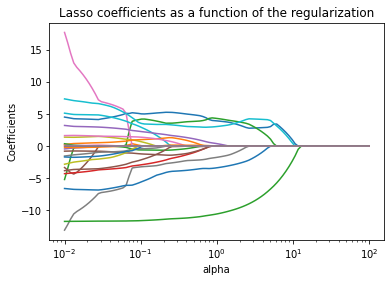

In [32]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X1_pu_train), y1_pu_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
# plt.legend(list(X1_pu_train.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

In [33]:
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X1_pu_train), y1_pu_train)

print('The best alpha from LassoCV for pickup model:', lassocv.alpha_)

The best alpha from LassoCV for pickup model: 1.5199110829529348


In [34]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X1_pu_train), y1_pu_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X1_pu_train.columns))

The coefficients are:
tempmax                    3.656262
tempmin                    0.000000
temp                       3.973187
feelslikemax               0.000000
feelslikemin               0.000000
feelslike                  0.000000
dew                        0.000000
humidity                  -1.294733
precip                    -0.000000
precipprob                -0.000000
precipcover               -2.992538
snow                       0.000000
snowdepth                 -0.000000
windspeed                 -0.000000
winddir                    0.000000
sealevelpressure          -0.000000
cloudcover                -0.000000
visibility                 0.000000
solarradiation             0.000000
solarenergy                3.356280
uvindex                    0.000000
moonphase                  0.000000
Day off                  -10.028170
Weekend                   -0.000000
icon_partly-cloudy-day     0.000000
icon_rain                 -0.000000
icon_snow                 -0.000000
icon_w

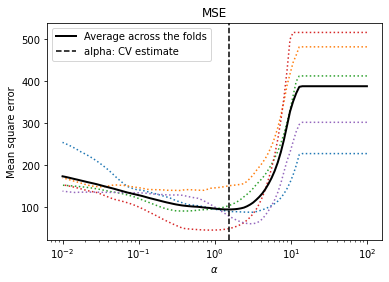

In [35]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [36]:
y1_pu_pred=lasso.predict(scale(X1_pu_test.values))
mse = round(mean_squared_error(y1_pu_test, y1_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 123.692


### Dropoff

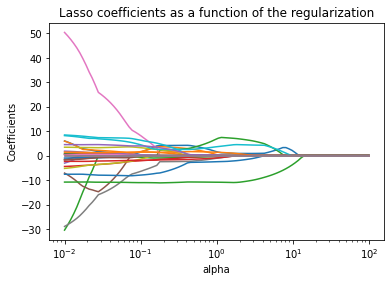

In [37]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X1_do_train), y1_do_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
# plt.legend(list(X1_do_train.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

In [38]:
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X1_do_train), y1_do_train)

print('The best alpha from LassoCV for dropoff model:', lassocv.alpha_)

The best alpha from LassoCV for dropoff model: 1.0476157527896652


In [39]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X1_do_train), y1_do_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X1_do_train.columns))

The coefficients are:
tempmax                    1.422580
tempmin                    0.224778
temp                       7.136991
feelslikemax               0.000000
feelslikemin               0.000000
feelslike                  0.000000
dew                        0.000000
humidity                  -0.989540
precip                    -0.000000
precipprob                -0.000000
precipcover               -2.463343
snow                      -0.000000
snowdepth                 -0.346855
windspeed                 -0.000000
winddir                   -0.000000
sealevelpressure           0.000000
cloudcover                -0.000000
visibility                 0.000000
solarradiation             0.000000
solarenergy                3.718231
uvindex                    0.000000
moonphase                  1.370337
Day off                  -10.881599
Weekend                   -0.879671
icon_partly-cloudy-day     0.203377
icon_rain                 -0.000000
icon_snow                 -0.000000
icon_w

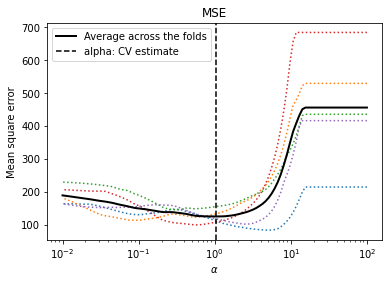

In [40]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [41]:
y1_do_pred=lasso.predict(scale(X1_do_test.values))
mse = round(mean_squared_error(y1_do_test, y1_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 95.868


## Ridge regression

### Pickup

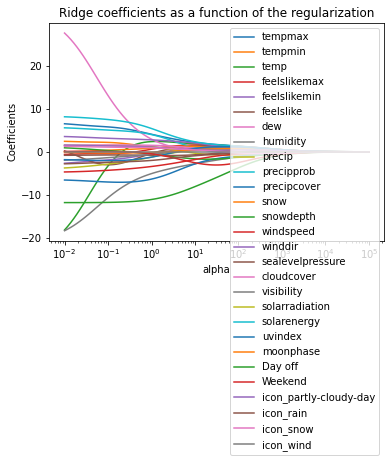

In [42]:
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X1_pu_train), y1_pu_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X1_pu.columns), loc='best')

plt.title('Ridge coefficients as a function of the regularization');

In [43]:
# standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X1_pu_train)

In [44]:
# set a large alpha to get smaller coefficients
ridge = Ridge(alpha=1000)
ridge.fit(scaler.transform(X1_pu_train), y1_pu_train)

print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X1_pu_train.columns))

The coefficients are:
tempmax                   0.514168
tempmin                   0.414919
temp                      0.496459
feelslikemax              0.510892
feelslikemin              0.431357
feelslike                 0.498650
dew                       0.251453
humidity                 -0.325985
precip                   -0.319819
precipprob               -0.243417
precipcover              -0.361270
snow                     -0.264505
snowdepth                -0.389178
windspeed                -0.141067
winddir                   0.091539
sealevelpressure          0.030812
cloudcover               -0.163178
visibility                0.295882
solarradiation            0.357532
solarenergy               0.493279
uvindex                   0.466512
moonphase                 0.196442
Day off                  -0.735126
Weekend                  -0.574844
icon_partly-cloudy-day    0.283240
icon_rain                -0.073564
icon_snow                -0.295255
icon_wind                 0.00000

In [45]:
# find the best alpha via CV with selected scoring metric
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X1_pu_train), y1_pu_train)

print('The best alpha from RidgeCV:', ridgecv.alpha_)

The best alpha from RidgeCV: 12.91549665014884


In [46]:
# with the best alpha
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X1_pu_train), y1_pu_train)
print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X1_pu_train.columns))

The coefficients are:
tempmax                   2.058813
tempmin                   0.991162
temp                      1.792036
feelslikemax              1.562713
feelslikemin              0.905561
feelslike                 1.325693
dew                       0.475687
humidity                 -2.571923
precip                   -0.449060
precipprob                0.655239
precipcover              -2.463495
snow                      1.188077
snowdepth                -1.684790
windspeed                -1.591384
winddir                   1.904539
sealevelpressure         -0.622054
cloudcover                0.690432
visibility                0.664050
solarradiation            0.345064
solarenergy               2.143987
uvindex                   0.922444
moonphase                 0.511364
Day off                  -7.632718
Weekend                  -2.740887
icon_partly-cloudy-day    0.454419
icon_rain                -0.824563
icon_snow                 0.389633
icon_wind                 0.00000

In [47]:
y1_pu_pred=ridge.predict(scale(X1_pu_test.values))
mse = round(mean_squared_error(y1_pu_test, y1_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 130.488


### Dropoff

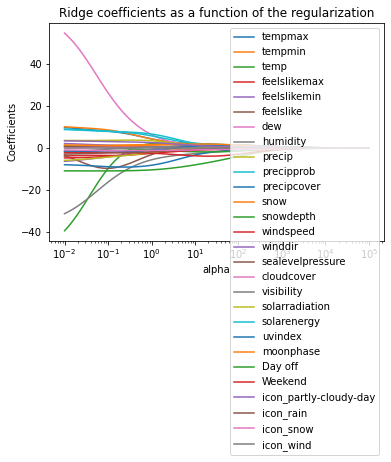

In [48]:
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X1_do_train), y1_do_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X1_do.columns), loc='best')

plt.title('Ridge coefficients as a function of the regularization');

In [49]:
# standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X1_do_train)

In [50]:
# set a large alpha to get smaller coefficients
ridge = Ridge(alpha=1000)
ridge.fit(scaler.transform(X1_do_train), y1_do_train)

print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X1_do_train.columns))

The coefficients are:
tempmax                   0.553979
tempmin                   0.481331
temp                      0.547176
feelslikemax              0.544423
feelslikemin              0.495701
feelslike                 0.548605
dew                       0.319064
humidity                 -0.285402
precip                   -0.247570
precipprob               -0.196768
precipcover              -0.328565
snow                     -0.335194
snowdepth                -0.452099
windspeed                -0.181076
winddir                  -0.029080
sealevelpressure          0.071491
cloudcover               -0.147064
visibility                0.273986
solarradiation            0.331134
solarenergy               0.482428
uvindex                   0.450777
moonphase                 0.293091
Day off                  -0.820879
Weekend                  -0.678111
icon_partly-cloudy-day    0.290454
icon_rain                -0.004141
icon_snow                -0.389893
icon_wind                 0.00000

In [51]:
# find the best alpha via CV with selected scoring metric
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X1_do_train), y1_do_train)

print('The best alpha from RidgeCV:', ridgecv.alpha_)

The best alpha from RidgeCV: 15.199110829529332


In [52]:
# with the best alpha
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X1_do_train), y1_do_train)
print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X1_do_train.columns))

The coefficients are:
tempmax                   1.770375
tempmin                   1.741825
temp                      1.832136
feelslikemax              0.997843
feelslikemin              1.313751
feelslike                 1.102581
dew                       0.947279
humidity                 -2.384789
precip                    0.595041
precipprob                1.420873
precipcover              -2.607731
snow                      1.102509
snowdepth                -1.862517
windspeed                -0.971454
winddir                   0.158869
sealevelpressure          0.183453
cloudcover                0.205749
visibility                1.194513
solarradiation            0.087203
solarenergy               1.960474
uvindex                   0.986329
moonphase                 1.856976
Day off                  -7.388132
Weekend                  -3.869019
icon_partly-cloudy-day    1.023305
icon_rain                -0.463235
icon_snow                -0.825436
icon_wind                 0.00000

In [53]:
y1_do_pred=ridge.predict(scale(X1_do_test.values))
mse = round(mean_squared_error(y1_do_test, y1_do_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 90.072


## Elastic Net

### Pickup

In [54]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X1_pu_train), y1_pu_train)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

The best alpha from ElasticNetCV: 0.24504227054374741


In [55]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X1_pu_train), y1_pu_train)

EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X1_pu_train), y1_pu_train)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X1_pu_train.columns))

The coefficients are:
tempmax                   2.360162
tempmin                   0.952790
temp                      2.006904
feelslikemax              1.606614
feelslikemin              0.760745
feelslike                 1.282062
dew                       0.099099
humidity                 -2.631780
precip                   -0.263388
precipprob                0.212669
precipcover              -2.881837
snow                      1.202859
snowdepth                -1.377450
windspeed                -1.450175
winddir                   1.805297
sealevelpressure         -0.654318
cloudcover                0.537855
visibility                0.279279
solarradiation            0.000000
solarenergy               2.405169
uvindex                   0.692256
moonphase                 0.425631
Day off                  -8.332045
Weekend                  -2.262707
icon_partly-cloudy-day    0.000000
icon_rain                -0.750172
icon_snow                 0.037302
icon_wind                 0.00000

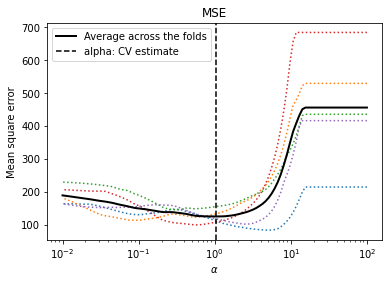

In [56]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [57]:
y1_pu_pred=lasso.predict(scale(X1_pu_test.values))
mse = round(mean_squared_error(y1_pu_test, y1_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 129.57


### Dropoff

In [58]:
ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X1_do_train), y1_do_train)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

The best alpha from ElasticNetCV: 0.22326241984565823


In [59]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X1_do_train), y1_do_train)

EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X1_do_train), y1_do_train)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X1_do_train.columns))

The coefficients are:
tempmax                   2.139468
tempmin                   1.945616
temp                      2.102128
feelslikemax              0.741775
feelslikemin              1.120018
feelslike                 0.735903
dew                       0.929743
humidity                 -2.601689
precip                    0.684013
precipprob                1.674241
precipcover              -3.279890
snow                      1.246453
snowdepth                -1.673998
windspeed                -0.945414
winddir                   0.000000
sealevelpressure          0.000000
cloudcover                0.032263
visibility                0.838117
solarradiation            0.000000
solarenergy               2.266529
uvindex                   0.602026
moonphase                 1.792985
Day off                  -8.417035
Weekend                  -3.448683
icon_partly-cloudy-day    1.300549
icon_rain                -0.136887
icon_snow                -0.738778
icon_wind                 0.00000

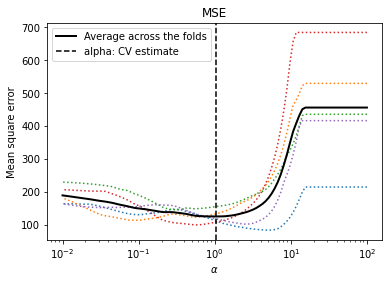

In [60]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [61]:
y1_pu_pred=lasso.predict(scale(X1_do_test.values))
mse = round(mean_squared_error(y1_do_test, y1_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 90.072


## KNN Regressor

### Pickup

In [62]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

In [63]:
mse_train_pu_1 = [-1]*40
mse_test_pu_1 = [-1]*40
for k in range(40):
    model = neighbors.KNeighborsRegressor(n_neighbors = k+1)
    model.fit(X1_pu_train, y1_pu_train)  #fit the model
# Training MSE and Test MSE    
    mse_train_pu_1[k] = mean_squared_error(y1_pu_train, model.predict(X1_pu_train))
    mse_test_pu_1[k] = mean_squared_error(y1_pu_test, model.predict(X1_pu_test))

In [64]:
# optimal MSE
min(mse_test_pu_1)

226.99739583333334

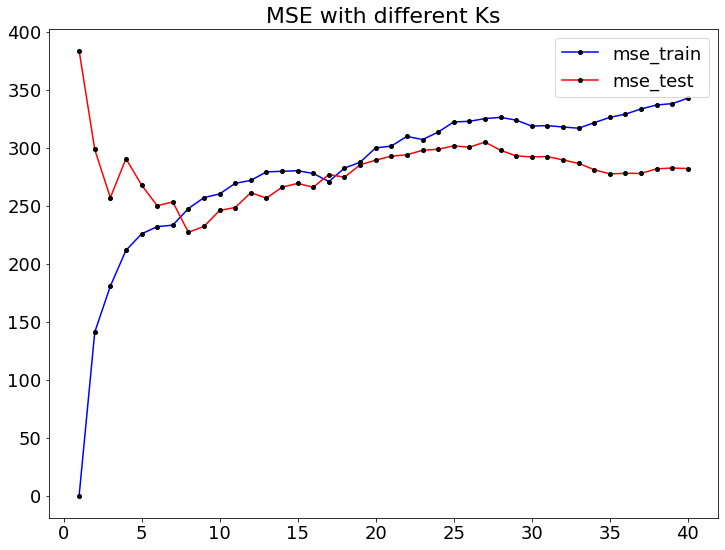

In [65]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(40)+1, mse_train_pu_1,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(40)+1, mse_test_pu_1,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

### Dropoff

In [66]:
mse_train_do_1 = [-1]*40
mse_test_do_1 = [-1]*40
for k in range(40):
    model = neighbors.KNeighborsRegressor(n_neighbors = k+1)
    model.fit(X1_do_train, y1_do_train)  #fit the model
# Training MSE and Test MSE    
    mse_train_do_1[k] = mean_squared_error(y1_do_train, model.predict(X1_do_train))
    mse_test_do_1[k] = mean_squared_error(y1_do_test, model.predict(X1_do_test))

In [67]:
# optimal MSE
min(mse_test_do_1)

210.54398148148144

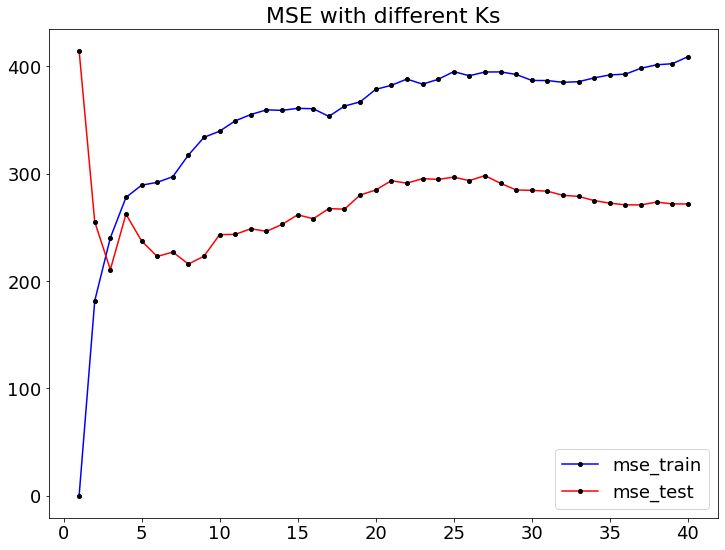

In [68]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(40)+1, mse_train_do_1,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(40)+1, mse_test_do_1,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

### Second, we work with '21st St & Pennsylvania Ave NW' station.

### Count daily pickups

In [69]:
# Group and get pickup occurrence for 21st St & Pennsylvania Ave NW
df_sub3 = df[df['start_station_name']=="21st St & Pennsylvania Ave NW"]
df_grp3 = df_sub3.groupby(['started_at_date','start_station_name']).size()
df_pu2=df_grp3.reset_index(name = "pu_ct_2")
df_pu2

,started_at_date,start_station_name,pu_ct_2
0,2022-01-01,21st St & Pennsylvania Ave NW,5
1,2022-01-02,21st St & Pennsylvania Ave NW,1
2,2022-01-03,21st St & Pennsylvania Ave NW,1
3,2022-01-05,21st St & Pennsylvania Ave NW,3
4,2022-01-06,21st St & Pennsylvania Ave NW,5
...,...,...,...
110,2022-04-26,21st St & Pennsylvania Ave NW,22
111,2022-04-27,21st St & Pennsylvania Ave NW,21
112,2022-04-28,21st St & Pennsylvania Ave NW,23
113,2022-04-29,21st St & Pennsylvania Ave NW,23


### Count daily dropoffs

In [70]:
# Group and get drop off occurrence for 21st St & Pennsylvania Ave NW
df_sub4 = df[df['end_station_name']=="21st St & Pennsylvania Ave NW"]
df_grp4 = df_sub4.groupby(['ended_at_date','end_station_name']).size()
df_do2=df_grp4.reset_index(name = "do_ct_2")
df_do2

,ended_at_date,end_station_name,do_ct_2
0,2022-01-01,21st St & Pennsylvania Ave NW,4
1,2022-01-02,21st St & Pennsylvania Ave NW,3
2,2022-01-03,21st St & Pennsylvania Ave NW,2
3,2022-01-04,21st St & Pennsylvania Ave NW,1
4,2022-01-05,21st St & Pennsylvania Ave NW,4
...,...,...,...
114,2022-04-26,21st St & Pennsylvania Ave NW,29
115,2022-04-27,21st St & Pennsylvania Ave NW,29
116,2022-04-28,21st St & Pennsylvania Ave NW,26
117,2022-04-29,21st St & Pennsylvania Ave NW,34


### Visualize pickups and dropoffs

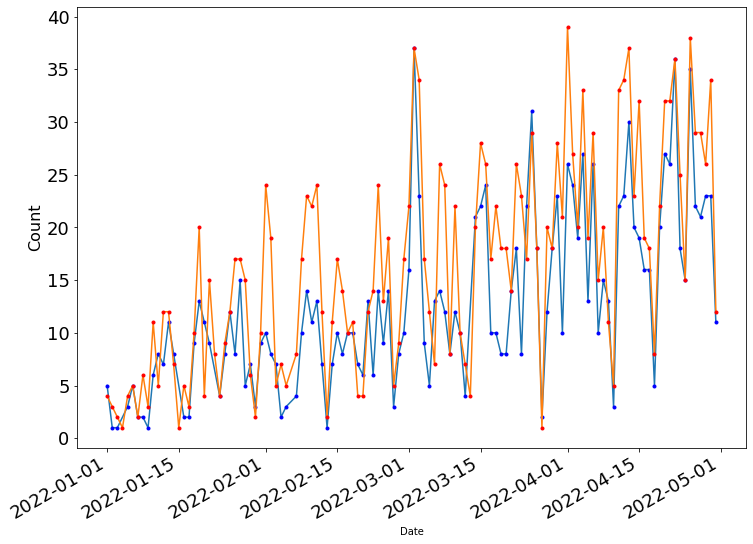

In [71]:
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( df_pu2['started_at_date'], df_pu2['pu_ct_2'],linestyle = 'solid',markeredgecolor = 'blue',markerfacecolor = 'blue', markersize = 3)
ax1.plot_date( df_do2['ended_at_date'], df_do2['do_ct_2'],linestyle = 'solid',markeredgecolor = 'red',markerfacecolor = 'red', markersize = 3)

ax1.set_xlabel('Date',fontsize=10)
ax1.set_ylabel('Count',fontsize=16)
plt.gcf().autofmt_xdate()

plt.tick_params(labelsize=18)
plt.show()  

## Prepare X and y: Merge weather data with trip data

In [72]:
# Merge with weather data and remove dates and station name

df_m_pu2 = df_pu2.merge(df_weather, left_on='started_at_date', right_on='datetime') 
df_m_pu2 = df_m_pu2.merge(calendar, left_on='datetime', right_on='date') 
df_m_pu2 = df_m_pu2.drop(columns=['started_at_date','start_station_name','datetime','date'])
df_m_do2 = df_do2.merge(df_weather, left_on='ended_at_date', right_on='datetime') 
df_m_do2 = df_m_do2.merge(calendar, left_on='ended_at_date', right_on='date') 
df_m_do2 = df_m_do2.drop(columns=['ended_at_date','end_station_name','datetime','date'])

In [73]:
df_m_pu2.head()

,pu_ct_2,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon,Day off,Weekend
0,5,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,...,1007.2,99.5,6.2,21.4,0.6,0,0.99,rain,1,1
1,1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,...,1006.6,91.6,9.6,47.3,1.7,1,1.00,rain,1,1
2,1,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,0.889,...,1019.7,77.2,6.2,6.3,0.0,0,0.00,snow,1,0
3,3,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,...,1014.5,82.6,9.9,63.5,2.2,1,0.05,partly-cloudy-day,1,0
4,5,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,...,1012.7,88.1,9.9,145.6,5.3,4,0.09,snow,1,0


In [74]:
df_m_do2.head()

,do_ct_2,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon,Day off,Weekend
0,4,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,...,1007.2,99.5,6.2,21.4,0.6,0,0.99,rain,1,1
1,3,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,...,1006.6,91.6,9.6,47.3,1.7,1,1.00,rain,1,1
2,2,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,0.889,...,1019.7,77.2,6.2,6.3,0.0,0,0.00,snow,1,0
3,1,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,...,1029.7,18.7,9.9,153.2,5.4,6,0.02,snow,1,0
4,4,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,...,1014.5,82.6,9.9,63.5,2.2,1,0.05,partly-cloudy-day,1,0


## Train linear models

In [75]:
# pickup
y2_pu = df_m_pu2['pu_ct_2']
X2_pu = df_m_pu2.drop('pu_ct_2',axis=1)
X2_pu = pd.get_dummies(data=X2_pu, drop_first=True)
X2_pu.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,solarradiation,solarenergy,uvindex,moonphase,Day off,Weekend,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
0,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,100,...,21.4,0.6,0,0.99,1,1,0,1,0,0
1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,100,...,47.3,1.7,1,1.00,1,1,0,1,0,0
2,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,0.889,100,...,6.3,0.0,0,0.00,1,0,0,0,1,0
3,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,0,...,63.5,2.2,1,0.05,1,0,1,0,0,0
4,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,0,...,145.6,5.3,4,0.09,1,0,0,0,1,0


In [76]:
X2_pu_train, X2_pu_test, y2_pu_train, y2_pu_test = train_test_split(X2_pu,y2_pu, test_size=0.4, random_state = 200)

In [77]:
# dropoff
y2_do = df_m_do2['do_ct_2']
X2_do = df_m_do2.drop('do_ct_2',axis=1)
X2_do = pd.get_dummies(data=X2_do, drop_first=True)
X2_do.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,solarradiation,solarenergy,uvindex,moonphase,Day off,Weekend,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
0,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,100,...,21.4,0.6,0,0.99,1,1,0,1,0,0
1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,100,...,47.3,1.7,1,1.00,1,1,0,1,0,0
2,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,0.889,100,...,6.3,0.0,0,0.00,1,0,0,0,1,0
3,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,0,...,153.2,5.4,6,0.02,1,0,0,0,1,0
4,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,0,...,63.5,2.2,1,0.05,1,0,1,0,0,0


In [78]:
X2_do_train, X2_do_test, y2_do_train, y2_do_test = train_test_split(X2_do,y2_do, test_size=0.4, random_state = 200)

## Linear Regression

### Pickup

In [79]:
linear_regressor = LinearRegression()
linear_regressor.fit(X2_pu_train, y2_pu_train) 
y2_pu_pred = linear_regressor.predict(X2_pu_test)

In [80]:
print(pd.Series(linear_regressor.coef_.flatten(), index=X2_pu_train.columns))

tempmax                   0.599298
tempmin                  -0.171484
temp                     -1.354980
feelslikemax             -0.557175
feelslikemin             -0.136500
feelslike                 0.286217
dew                       1.784757
humidity                 -0.845306
precip                   -1.444354
precipprob                0.017945
precipcover              -0.044936
snow                      1.574637
snowdepth                 0.776832
windspeed                -0.438413
winddir                   0.018761
sealevelpressure         -0.209716
cloudcover                0.013177
visibility               -2.432978
solarradiation           -0.008681
solarenergy               0.671767
uvindex                   0.825445
moonphase                 3.342698
Day off                  -4.492820
Weekend                  -4.437531
icon_partly-cloudy-day    2.148166
icon_rain                 0.136959
icon_snow                -0.248020
icon_wind                 0.000000
dtype: float64


In [81]:
mse = round(mean_squared_error(y2_pu_test, y2_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 44.093


### Dropoff

In [82]:
linear_regressor = LinearRegression()
linear_regressor.fit(X2_do_train, y2_do_train) 
y2_do_pred = linear_regressor.predict(X2_do_test)

In [83]:
print(pd.Series(linear_regressor.coef_.flatten(), index=X2_do_train.columns))

tempmax                    1.055380
tempmin                    1.080724
temp                      -3.858308
feelslikemax              -0.595644
feelslikemin              -0.254886
feelslike                  1.243486
dew                        1.870843
humidity                  -0.995725
precip                    16.451210
precipprob                 0.006570
precipcover               -0.156935
snow                       0.252845
snowdepth                 -0.839011
windspeed                 -0.377580
winddir                    0.017235
sealevelpressure           0.061523
cloudcover                 0.049748
visibility                 0.088689
solarradiation            -0.003032
solarenergy                0.499468
uvindex                    0.236627
moonphase                 -3.215664
Day off                   -6.183550
Weekend                   -6.340213
icon_partly-cloudy-day    -0.813002
icon_rain                 -2.788976
icon_snow                  1.008439
icon_wind                  2

In [84]:
mse = round(mean_squared_error(y2_do_test, y2_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 54.633


## LASSO

### Pickup

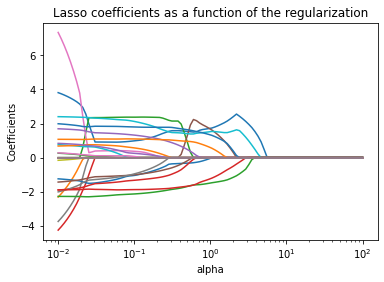

In [85]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X2_pu_train), y2_pu_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
# plt.legend(list(X2_pu_train.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

In [86]:
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X2_pu_train), y2_pu_train)

print('The best alpha from LassoCV for pickup model:', lassocv.alpha_)

The best alpha from LassoCV for pickup model: 0.23644894126454083


In [87]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X2_pu_train), y2_pu_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X2_pu_train.columns))

The coefficients are:
tempmax                   1.416962
tempmin                   0.000000
temp                      2.318125
feelslikemax              0.000000
feelslikemin              0.000000
feelslike                 0.000000
dew                       0.000000
humidity                  0.000000
precip                   -0.000000
precipprob               -0.000000
precipcover              -0.572249
snow                      0.183820
snowdepth                 0.000000
windspeed                -1.125123
winddir                   1.037712
sealevelpressure         -0.739133
cloudcover                0.000000
visibility               -0.278517
solarradiation            0.000000
solarenergy               1.631034
uvindex                   1.779120
moonphase                 1.049575
Day off                  -1.955622
Weekend                  -1.828731
icon_partly-cloudy-day    0.045497
icon_rain                -0.000000
icon_snow                 0.000000
icon_wind                 0.00000

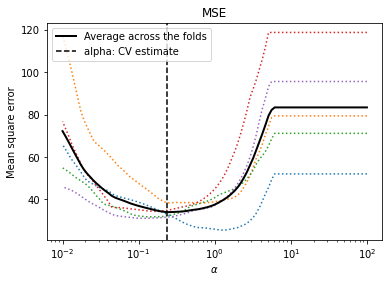

In [88]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [89]:
y2_pu_pred=lasso.predict(scale(X2_pu_test.values))
mse = round(mean_squared_error(y2_pu_test, y2_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 30.722


### Dropoff

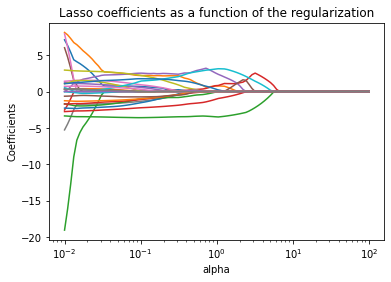

In [90]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X2_do_train), y2_do_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
# plt.legend(list(X2_do_train.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

In [91]:
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X2_do_train), y2_do_train)

print('The best alpha from LassoCV for dropoff model:', lassocv.alpha_)

The best alpha from LassoCV for dropoff model: 0.8697490026177834


In [92]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X2_do_train), y2_do_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X2_do_train.columns))

The coefficients are:
tempmax                   0.000000
tempmin                   0.696593
temp                      0.000000
feelslikemax              0.666302
feelslikemin              2.788620
feelslike                 0.000000
dew                       0.000000
humidity                 -0.000000
precip                    0.000000
precipprob               -0.000000
precipcover              -0.000000
snow                     -0.000000
snowdepth                -0.189420
windspeed                -0.000000
winddir                  -0.000000
sealevelpressure         -0.000000
cloudcover                0.000000
visibility                0.000000
solarradiation            0.000000
solarenergy               3.020957
uvindex                   0.491150
moonphase                -0.000000
Day off                  -3.434580
Weekend                  -1.207244
icon_partly-cloudy-day    0.000000
icon_rain                -0.000000
icon_snow                -0.000000
icon_wind                -0.00000

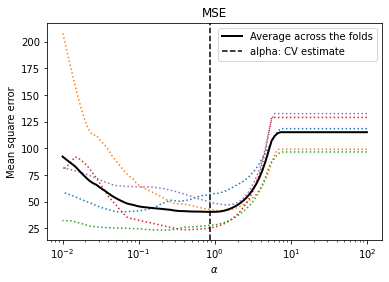

In [93]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [94]:
y2_do_pred=lasso.predict(scale(X2_do_test.values))
mse = round(mean_squared_error(y2_do_test, y2_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 38.135


## Ridge regression

### Pickup

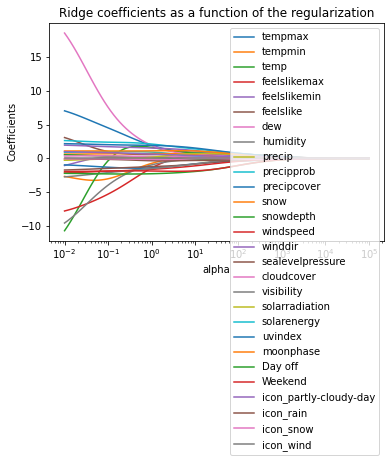

In [95]:
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X2_pu_train), y2_pu_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X2_pu.columns), loc='best')

plt.title('Ridge coefficients as a function of the regularization');

In [96]:
# standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X2_pu_train)

In [97]:
# set a large alpha to get smaller coefficients
ridge = Ridge(alpha=1000)
ridge.fit(scaler.transform(X2_pu_train), y2_pu_train)

print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X2_pu_train.columns))

The coefficients are:
tempmax                   0.257170
tempmin                   0.198088
temp                      0.238898
feelslikemax              0.253490
feelslikemin              0.213053
feelslike                 0.241978
dew                       0.159147
humidity                 -0.075988
precip                   -0.115308
precipprob               -0.091253
precipcover              -0.141239
snow                     -0.108613
snowdepth                -0.135573
windspeed                -0.086857
winddir                   0.038731
sealevelpressure         -0.022176
cloudcover               -0.030995
visibility                0.063921
solarradiation            0.185218
solarenergy               0.235023
uvindex                   0.222723
moonphase                 0.103927
Day off                  -0.219650
Weekend                  -0.214710
icon_partly-cloudy-day    0.129590
icon_rain                -0.040100
icon_snow                -0.123425
icon_wind                 0.00000

In [98]:
# find the best alpha via CV with selected scoring metric
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X2_pu_train), y2_pu_train)

print('The best alpha from RidgeCV:', ridgecv.alpha_)

The best alpha from RidgeCV: 29.150530628251758


In [99]:
# with the best alpha
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X2_pu_train), y2_pu_train)
print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X2_pu_train.columns))

The coefficients are:
tempmax                   0.777224
tempmin                   0.388025
temp                      0.658871
feelslikemax              0.671961
feelslikemin              0.476265
feelslike                 0.621426
dew                       0.462610
humidity                 -0.126061
precip                   -0.318413
precipprob                0.013487
precipcover              -0.581402
snow                      0.254697
snowdepth                -0.292771
windspeed                -0.782292
winddir                   0.766184
sealevelpressure         -0.538390
cloudcover                0.068262
visibility               -0.421549
solarradiation            0.696265
solarenergy               1.079740
uvindex                   1.165921
moonphase                 0.912219
Day off                  -1.607445
Weekend                  -1.594861
icon_partly-cloudy-day    0.325120
icon_rain                -0.266671
icon_snow                -0.003262
icon_wind                 0.00000

In [100]:
y2_pu_pred=ridge.predict(scale(X2_pu_test.values))
mse = round(mean_squared_error(y2_pu_test, y2_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 29.883


### Dropoff

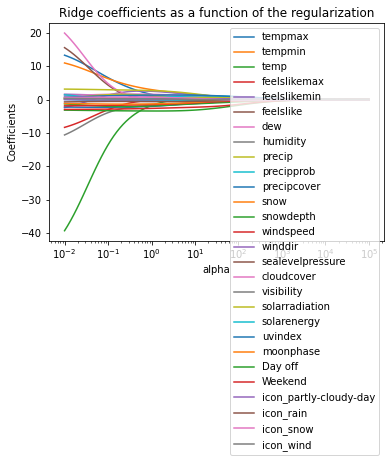

In [101]:
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X2_do_train), y2_do_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.legend(list(X2_do.columns), loc='best')

plt.title('Ridge coefficients as a function of the regularization');

In [102]:
# standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X2_do_train)

In [103]:
# set a large alpha to get smaller coefficients
ridge = Ridge(alpha=1000)
ridge.fit(scaler.transform(X2_do_train), y2_do_train)

print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X2_do_train.columns))

The coefficients are:
tempmax                   0.293223
tempmin                   0.262786
temp                      0.278517
feelslikemax              0.295459
feelslikemin              0.265548
feelslike                 0.284907
dew                       0.198805
humidity                 -0.072359
precip                   -0.010912
precipprob               -0.078503
precipcover              -0.098207
snow                     -0.138962
snowdepth                -0.195532
windspeed                -0.100079
winddir                  -0.026924
sealevelpressure         -0.023125
cloudcover               -0.032501
visibility                0.051941
solarradiation            0.204610
solarenergy               0.292546
uvindex                   0.267710
moonphase                 0.030381
Day off                  -0.346540
Weekend                  -0.303778
icon_partly-cloudy-day    0.127371
icon_rain                -0.020615
icon_snow                -0.163244
icon_wind                 0.01604

In [104]:
# find the best alpha via CV with selected scoring metric
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X2_do_train), y2_do_train)

print('The best alpha from RidgeCV:', ridgecv.alpha_)

The best alpha from RidgeCV: 24.77076355991709


In [105]:
# with the best alpha
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X2_do_train), y2_do_train)
print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X2_do_train.columns))

The coefficients are:
tempmax                   0.627906
tempmin                   1.126303
temp                      0.627883
feelslikemax              0.606360
feelslikemin              1.073566
feelslike                 0.744031
dew                       0.257880
humidity                 -0.848272
precip                    1.126837
precipprob               -0.282450
precipcover              -0.506473
snow                     -0.013102
snowdepth                -1.039095
windspeed                -0.692070
winddir                   0.197642
sealevelpressure         -0.097157
cloudcover                0.500606
visibility                0.073828
solarradiation            0.648129
solarenergy               1.134536
uvindex                   1.218566
moonphase                -0.486082
Day off                  -2.690617
Weekend                  -2.062541
icon_partly-cloudy-day    0.232534
icon_rain                -0.390445
icon_snow                 0.142171
icon_wind                 0.00862

In [106]:
y2_do_pred=ridge.predict(scale(X2_do_test.values))
mse = round(mean_squared_error(y2_do_test, y2_do_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 41.068


## Elastic Net

### Pickup

In [107]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X2_pu_train), y2_pu_train)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

The best alpha from ElasticNetCV: 0.41925947459590185


In [108]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X2_pu_train), y2_pu_train)

EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X2_pu_train), y2_pu_train)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X2_pu_train.columns))

The coefficients are:
tempmax                   0.893874
tempmin                   0.212826
temp                      0.718382
feelslikemax              0.702553
feelslikemin              0.438815
feelslike                 0.656743
dew                       0.301371
humidity                 -0.000000
precip                   -0.069197
precipprob               -0.000000
precipcover              -0.498128
snow                      0.025180
snowdepth                -0.000000
windspeed                -0.681350
winddir                   0.724717
sealevelpressure         -0.446131
cloudcover                0.000000
visibility               -0.080718
solarradiation            0.432582
solarenergy               1.243697
uvindex                   1.346869
moonphase                 0.986155
Day off                  -1.738540
Weekend                  -1.624094
icon_partly-cloudy-day    0.144124
icon_rain                -0.125616
icon_snow                 0.000000
icon_wind                 0.00000

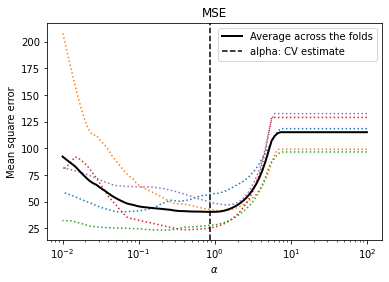

In [109]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [110]:
y2_pu_pred=lasso.predict(scale(X2_pu_test.values))
mse = round(mean_squared_error(y2_pu_test, y2_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 25.824


### Dropoff

In [111]:
ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X2_do_train), y2_do_train)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

The best alpha from ElasticNetCV: 0.39217596088545065


In [112]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X2_do_train), y2_do_train)

EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X2_do_train), y2_do_train)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X2_do_train.columns))

The coefficients are:
tempmax                   0.544327
tempmin                   1.318964
temp                      0.520780
feelslikemax              0.537832
feelslikemin              1.255159
feelslike                 0.746541
dew                       0.000000
humidity                 -0.652438
precip                    0.915550
precipprob               -0.129053
precipcover              -0.368489
snow                     -0.000000
snowdepth                -0.920360
windspeed                -0.506797
winddir                   0.000000
sealevelpressure         -0.000000
cloudcover                0.200022
visibility                0.000000
solarradiation            0.393952
solarenergy               1.303273
uvindex                   1.338377
moonphase                -0.357161
Day off                  -2.869069
Weekend                  -2.016879
icon_partly-cloudy-day    0.157091
icon_rain                -0.349762
icon_snow                 0.000000
icon_wind                -0.00000

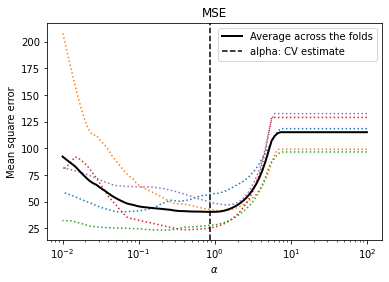

In [113]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [114]:
y2_pu_pred=lasso.predict(scale(X2_do_test.values))
mse = round(mean_squared_error(y2_do_test, y2_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 41.068


## KNN Regressor

### Pickup

In [115]:
mse_train_pu_2 = [-1]*40
mse_test_pu_2 = [-1]*40
for k in range(40):
    model = neighbors.KNeighborsRegressor(n_neighbors = k+1)
    model.fit(X2_pu_train, y2_pu_train)  #fit the model
# Training MSE and Test MSE    
    mse_train_pu_2[k] = mean_squared_error(y2_pu_train, model.predict(X2_pu_train))
    mse_test_pu_2[k] = mean_squared_error(y2_pu_test, model.predict(X2_pu_test))

In [116]:
# optimal MSE
min(mse_test_pu_2)

33.74422554347826

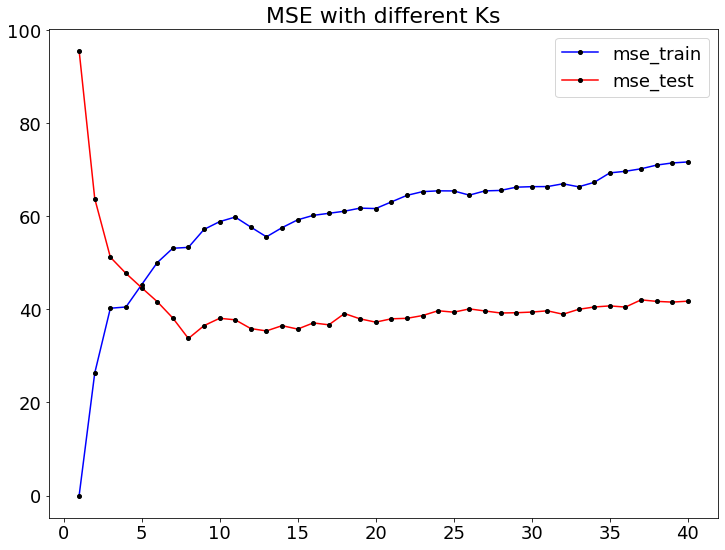

In [117]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(40)+1, mse_train_pu_2,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(40)+1, mse_test_pu_2,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

### Dropoff

In [118]:
mse_train_do_2 = [-1]*40
mse_test_do_2 = [-1]*40
for k in range(40):
    model = neighbors.KNeighborsRegressor(n_neighbors = k+1)
    model.fit(X2_do_train, y2_do_train)  #fit the model
# Training MSE and Test MSE    
    mse_train_do_2[k] = mean_squared_error(y2_do_train, model.predict(X2_do_train))
    mse_test_do_2[k] = mean_squared_error(y2_do_test, model.predict(X2_do_test))

In [119]:
# optimal MSE
min(mse_test_do_2)

60.203333333333326

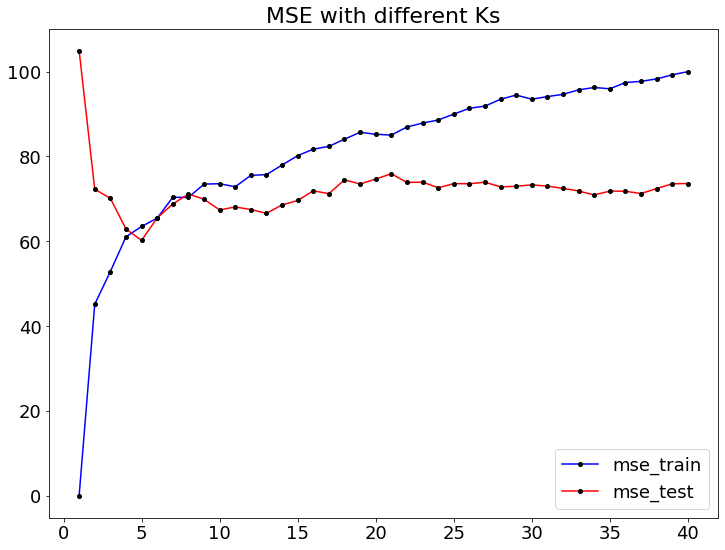

In [120]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(40)+1, mse_train_do_2,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(40)+1, mse_test_do_2,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

## Model comparison and select the best one for final training

After taking all models into consideration, we choose LASSO to train a final model. Before doing so, we will drop some features with coefficients of 0 in the model with the best alpha from LassoCV acrossing pickup and dropoff LASSO models of the two stations.

### 21st & I St NW station

In [121]:
df_m_pu1=df_m_pu1.drop(columns=['feelslike','dew','precip','precipprob','cloudcover','solarradiation','icon'])

In [122]:
df_m_do1=df_m_do1.drop(columns=['feelslike','dew','precip','precipprob','cloudcover','solarradiation','icon'])

In [123]:
df_m_pu1.head()

,pu_ct_1,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,7,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,5,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,2,34.0,25.3,29.4,33.7,16.0,65.7,0.00,2.8,6.7,14.1,192.1,1029.7,9.9,5.4,6,0.02,1,0
3,5,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0
4,10,42.9,36.9,39.8,40.6,29.5,55.0,0.00,0.9,3.4,12.9,16.0,1012.7,9.9,5.3,4,0.09,1,0


In [124]:
df_m_do1.head()

,do_ct_1,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,5,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,5,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,6,34.0,25.3,29.4,33.7,16.0,65.7,0.00,2.8,6.7,14.1,192.1,1029.7,9.9,5.4,6,0.02,1,0
3,5,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0
4,10,42.9,36.9,39.8,40.6,29.5,55.0,0.00,0.9,3.4,12.9,16.0,1012.7,9.9,5.3,4,0.09,1,0


In [125]:
from sklearn.metrics import r2_score

In [126]:
# pickup
y1_pu = df_m_pu1['pu_ct_1']
X1_pu = df_m_pu1.drop('pu_ct_1',axis=1)
X1_pu.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,34.0,25.3,29.4,33.7,16.0,65.7,0.00,2.8,6.7,14.1,192.1,1029.7,9.9,5.4,6,0.02,1,0
3,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0
4,42.9,36.9,39.8,40.6,29.5,55.0,0.00,0.9,3.4,12.9,16.0,1012.7,9.9,5.3,4,0.09,1,0


In [127]:
X1_pu_train,X1_pu_test, y1_pu_train,y1_pu_test = train_test_split(X1_pu,y1_pu, test_size=0.4, random_state = 200)

In [128]:
# dropoff
y1_do = df_m_do1['do_ct_1']
X1_do = df_m_do1.drop('do_ct_1',axis=1)
X1_do.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,34.0,25.3,29.4,33.7,16.0,65.7,0.00,2.8,6.7,14.1,192.1,1029.7,9.9,5.4,6,0.02,1,0
3,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0
4,42.9,36.9,39.8,40.6,29.5,55.0,0.00,0.9,3.4,12.9,16.0,1012.7,9.9,5.3,4,0.09,1,0


In [129]:
X1_do_train,X1_do_test, y1_do_train,y1_do_test = train_test_split(X1_do,y1_do, test_size=0.4, random_state = 200)

### Pickup

In [130]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X1_pu_train), y1_pu_train)
    coefs.append(lasso.coef_)
    
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X1_pu_train), y1_pu_train)

print('The best alpha from LassoCV for pickup model:', lassocv.alpha_)

The best alpha from LassoCV for pickup model: 1.384886371393873


In [131]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X1_pu_train), y1_pu_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X1_pu_train.columns))

The coefficients are:
tempmax              3.744715
tempmin              0.000000
temp                 4.049861
feelslikemax         0.000000
feelslikemin         0.000000
humidity            -1.432610
precipcover         -3.089020
snow                 0.000000
snowdepth           -0.000000
windspeed           -0.000000
winddir              0.060118
sealevelpressure    -0.000000
visibility           0.000000
solarenergy          3.261143
uvindex              0.000000
moonphase            0.000000
Day off            -10.159226
Weekend             -0.000000
dtype: float64


In [132]:
lasso.coef_

array([  3.74471452,   0.        ,   4.04986095,   0.        ,
         0.        ,  -1.4326104 ,  -3.08901999,   0.        ,
        -0.        ,  -0.        ,   0.06011753,  -0.        ,
         0.        ,   3.26114338,   0.        ,   0.        ,
       -10.15922609,  -0.        ])

In [133]:
lasso.intercept_ 

32.871428571428574

In [134]:
y1_pu_pred=lasso.predict(scale(X1_pu_test.values))
mse = round(mean_squared_error(y1_pu_test, y1_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 124.962


In [135]:
r2_pu_1 = round(r2_score(y1_pu_test, y1_pu_pred),3)
print(f"R-squared value for the LASSO pickup model of the 21st & I St NW station is {r2_pu_1}")

R-squared value for the LASSO pickup model of the 21st & I St NW station is 0.593


In [136]:
print(y1_pu_pred)

[34.88082295 40.87953866 11.90098059  7.95761857 44.00193415 29.11262723
  5.07363816 24.16619917 54.42533257  5.7040585  49.27208655 36.23714966
 47.76803469 35.5907098  35.09260829 46.79092206 18.37856742 60.35526994
 30.9866777  41.40598576 48.27747848 49.18758816 37.97005476 41.26208477
 18.95059245 44.08830767 39.69662887 25.02828168 34.57603277 16.61183024
 20.60206647 35.4090088  48.85777239 23.72359421  5.77563579 52.36116391
 52.11036703 33.56913076 32.55297355 19.10226997 39.17270571 43.92874354
 23.39615705 31.54358119 48.55303633  3.84992035 29.8871393  17.80366284]


In [137]:
print(y1_pu_pred[35])

52.36116391313556


In [138]:
print(y1_pu_test.iloc[35])

67


In [139]:
X1_pu_test.iloc[[35], :]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
114,61.8,46.8,54.6,61.8,40.4,39.4,0.0,0.0,0.0,21.0,315.0,1018.7,9.9,11.3,9,0.95,0,0


In [140]:
print(X1_pu_test)

     tempmax  tempmin  temp  feelslikemax  feelslikemin  humidity  \
72      71.8     44.3  57.5          71.8          41.9      51.6   
66      51.8     36.5  44.5          51.8          30.0      63.1   
34      34.9     26.6  31.2          24.7          17.2      49.7   
21      38.9     24.5  31.8          35.5          18.6      50.0   
86      57.8     36.3  47.0          57.8          32.8      48.3   
9       28.8     22.9  25.8          22.4           9.2      41.1   
13      33.8     20.5  25.8          23.1           9.2      39.5   
36      43.8     32.7  37.5          42.4          27.4      67.6   
98      66.2     39.4  52.4          66.2          34.7      53.1   
2       34.0     25.3  29.4          33.7          16.0      65.7   
67      61.9     37.3  49.2          61.9          34.0      66.7   
10      46.9     22.8  34.5          41.7          13.0      49.1   
87      73.9     51.9  63.5          73.9          51.9      70.2   
110     76.9     52.6  64.7       

In [141]:
df_pu1.iloc[114]

started_at_date           2022-04-27
start_station_name    21st & I St NW
pu_ct_1                           67
Name: 114, dtype: object

### Dropoff

In [142]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X1_do_train), y1_do_train)
    coefs.append(lasso.coef_)

# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X1_do_train), y1_do_train)

print('The best alpha from LassoCV for dropoff model:', lassocv.alpha_)

The best alpha from LassoCV for dropoff model: 0.9545484566618342


In [143]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X1_do_train), y1_do_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X1_do_train.columns))

The coefficients are:
tempmax              1.786444
tempmin              0.561100
temp                 6.569241
feelslikemax         0.000000
feelslikemin         0.000000
humidity            -1.149647
precipcover         -2.626703
snow                -0.000000
snowdepth           -0.422703
windspeed           -0.067089
winddir             -0.000000
sealevelpressure     0.000000
visibility           0.000000
solarenergy          3.642125
uvindex              0.000000
moonphase            1.396503
Day off            -10.865948
Weekend             -0.987204
dtype: float64


In [144]:
lasso.coef_

array([  1.78644443,   0.56110016,   6.56924075,   0.        ,
         0.        ,  -1.14964674,  -2.62670309,  -0.        ,
        -0.42270307,  -0.06708931,  -0.        ,   0.        ,
         0.        ,   3.64212546,   0.        ,   1.39650262,
       -10.86594771,  -0.98720412])

In [145]:
lasso.intercept_ 

35.24285714285714

In [146]:
y1_do_pred=lasso.predict(scale(X1_do_test.values))
mse = round(mean_squared_error(y1_do_test, y1_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 96.052


In [147]:
r2_do_1 = round(r2_score(y1_do_test, y1_do_pred),3)
print(f"R-squared value for the LASSO dropoff model of the 21st & I St NW station is {r2_do_1}")

R-squared value for the LASSO dropoff model of the 21st & I St NW station is 0.681


In [148]:
print(y1_do_pred)

[37.82634066 43.6522134   8.68298311  6.65066623 50.2682714  29.95081064
  1.78393659 26.71988283 57.89145101  1.52923161 52.3838316  36.93532547
 55.41176032 38.64253687 37.8470976  51.02246676 15.92474364 65.85150138
 32.32602814 42.87320422 53.80772887 51.99445342 42.73123566 45.84685767
 23.55717626 46.00902141 41.24690923 26.78827847 35.00314426 18.0072477
 26.01034898 37.3042251  52.45767377 23.85582473  5.28844377 59.579026
 56.40859355 41.24959623 34.92458186 19.74823713 41.40885441 46.57349581
 28.97037569 34.89083319 50.40063872  1.67948287 35.53533924 16.20523539]


In [149]:
print(y1_do_pred[35])

59.57902600442333


In [150]:
print(y1_do_test.iloc[35])

53


In [151]:
X1_do_test.iloc[[35], :]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
114,61.8,46.8,54.6,61.8,40.4,39.4,0.0,0.0,0.0,21.0,315.0,1018.7,9.9,11.3,9,0.95,0,0


In [152]:
print(X1_do_test)

     tempmax  tempmin  temp  feelslikemax  feelslikemin  humidity  \
72      71.8     44.3  57.5          71.8          41.9      51.6   
66      51.8     36.5  44.5          51.8          30.0      63.1   
34      34.9     26.6  31.2          24.7          17.2      49.7   
21      38.9     24.5  31.8          35.5          18.6      50.0   
86      57.8     36.3  47.0          57.8          32.8      48.3   
9       28.8     22.9  25.8          22.4           9.2      41.1   
13      33.8     20.5  25.8          23.1           9.2      39.5   
36      43.8     32.7  37.5          42.4          27.4      67.6   
98      66.2     39.4  52.4          66.2          34.7      53.1   
2       34.0     25.3  29.4          33.7          16.0      65.7   
67      61.9     37.3  49.2          61.9          34.0      66.7   
10      46.9     22.8  34.5          41.7          13.0      49.1   
87      73.9     51.9  63.5          73.9          51.9      70.2   
110     76.9     52.6  64.7       

In [153]:
df_do1.iloc[114]

ended_at_date           2022-04-27
end_station_name    21st & I St NW
do_ct_1                         53
Name: 114, dtype: object

For the station “21st St & I St NW”, we try to predict the ridership on January 7, a rainy day off. Based on
the prediction, we find that there would be approximately 4 pickups and 2 drop-offs. Therefore, we may need to put 2 bikes available at that location in use. Picking April 27, a non day off with normal weather, there would be around 52 pickups and 60 drop-offs. In this case, it might be due to some external reasons we explain in the summary.

### 21st St & Pennsylvania Ave NW station

In [154]:
df_m_pu2=df_m_pu2.drop(columns=['feelslike','dew','precip','precipprob','cloudcover','solarradiation','icon'])

In [155]:
df_m_do2=df_m_do2.drop(columns=['feelslike','dew','precip','precipprob','cloudcover','solarradiation','icon'])

In [156]:
df_m_pu2.head()

,pu_ct_2,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,5,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,1,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,1,46.0,26.1,32.7,39.4,14.3,78.7,62.50,5.0,1.8,22.5,358.5,1019.7,6.2,0.0,0,0.00,1,0
3,3,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0
4,5,42.9,36.9,39.8,40.6,29.5,55.0,0.00,0.9,3.4,12.9,16.0,1012.7,9.9,5.3,4,0.09,1,0


In [157]:
df_m_do2.head()

,do_ct_2,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,4,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,3,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,2,46.0,26.1,32.7,39.4,14.3,78.7,62.50,5.0,1.8,22.5,358.5,1019.7,6.2,0.0,0,0.00,1,0
3,1,34.0,25.3,29.4,33.7,16.0,65.7,0.00,2.8,6.7,14.1,192.1,1029.7,9.9,5.4,6,0.02,1,0
4,4,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0


In [158]:
# pickup
y2_pu = df_m_pu2['pu_ct_2']
X2_pu = df_m_pu2.drop('pu_ct_2',axis=1)
X2_pu.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,46.0,26.1,32.7,39.4,14.3,78.7,62.50,5.0,1.8,22.5,358.5,1019.7,6.2,0.0,0,0.00,1,0
3,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0
4,42.9,36.9,39.8,40.6,29.5,55.0,0.00,0.9,3.4,12.9,16.0,1012.7,9.9,5.3,4,0.09,1,0


In [159]:
X2_pu_train, X2_pu_test, y2_pu_train, y2_pu_test = train_test_split(X2_pu,y2_pu, test_size=0.4, random_state = 200)

In [160]:
# dropoff
y2_do = df_m_do2['do_ct_2']
X2_do = df_m_do2.drop('do_ct_2',axis=1)
X2_do.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
0,63.5,54.1,58.3,63.5,54.1,92.1,33.33,0.0,0.0,11.4,190.2,1007.2,6.2,0.6,0,0.99,1,1
1,62.7,47.8,57.5,62.7,42.0,81.6,29.17,0.0,0.0,18.9,290.7,1006.6,9.6,1.7,1,1.00,1,1
2,46.0,26.1,32.7,39.4,14.3,78.7,62.50,5.0,1.8,22.5,358.5,1019.7,6.2,0.0,0,0.00,1,0
3,34.0,25.3,29.4,33.7,16.0,65.7,0.00,2.8,6.7,14.1,192.1,1029.7,9.9,5.4,6,0.02,1,0
4,40.8,28.1,35.8,37.2,19.8,76.3,0.00,0.0,4.9,13.6,195.2,1014.5,9.9,2.2,1,0.05,1,0


In [161]:
X2_do_train, X2_do_test, y2_do_train, y2_do_test = train_test_split(X2_do,y2_do, test_size=0.4, random_state = 200)

### Pickup

In [162]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X2_pu_train), y2_pu_train)
    coefs.append(lasso.coef_)
    
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X2_pu_train), y2_pu_train)

print('The best alpha from LassoCV for pickup model:', lassocv.alpha_)

The best alpha from LassoCV for pickup model: 0.23644894126454083


In [163]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X2_pu_train), y2_pu_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X2_pu_train.columns))

The coefficients are:
tempmax             1.424814
tempmin             0.000000
temp                2.316171
feelslikemax        0.000000
feelslikemin        0.000000
humidity            0.000000
precipcover        -0.597692
snow                0.177951
snowdepth           0.000000
windspeed          -1.128512
winddir             1.043259
sealevelpressure   -0.725020
visibility         -0.278745
solarenergy         1.629693
uvindex             1.779700
moonphase           1.044152
Day off            -1.955002
Weekend            -1.831334
dtype: float64


In [164]:
lasso.coef_

array([ 1.42481424,  0.        ,  2.3161707 ,  0.        ,  0.        ,
        0.        , -0.59769206,  0.1779509 ,  0.        , -1.12851227,
        1.04325933, -0.72502025, -0.27874495,  1.62969302,  1.77969994,
        1.04415248, -1.95500197, -1.83133371])

In [165]:
lasso.intercept_ 

12.826086956521742

In [166]:
y2_pu_pred=lasso.predict(scale(X2_pu_test.values))
mse = round(mean_squared_error(y2_pu_test, y2_pu_pred),3)
print(f"Pickup MSE is {mse}")

Pickup MSE is 30.728


In [167]:
r2_pu_2 = round(r2_score(y2_pu_test, y2_pu_pred),3)
print(f"R-squared value for the LASSO pickup model of the 21st & I St NW station is {r2_pu_2}")

R-squared value for the LASSO pickup model of the 21st & I St NW station is 0.335


In [168]:
print(y2_pu_pred)

[-1.32945969 17.59243152  8.75673714 15.18642112 11.29686082 12.31027526
 16.38734234  7.53488491 10.95975872  6.03781961 17.1599604   0.45424019
 20.10141656 18.63029703 22.05134745 24.08698454 15.29135295 19.25684968
  9.68973099 23.16070292 13.80012828 18.40190318  5.90607542 17.47806379
 26.64368969 10.45376504 14.26264405 19.84067714 -1.58215808 12.61153152
 15.91302858 -8.86217171 11.60237515  7.75706545 14.85612895  6.93905042
 10.73076953 22.38533829 14.08866082  3.53192308 10.29696045 15.08784107
 20.47047975 10.59683155  9.39344255 12.7800016 ]


In [169]:
print(y2_pu_pred[21])

18.401903181414216


In [170]:
print(y2_pu_test.iloc[21])

15


In [171]:
X2_pu_test.iloc[[21], :]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
92,62.8,46.5,54.3,62.8,43.1,56.1,4.17,0.0,0.0,19.5,230.9,1005.1,9.7,10.4,5,0.21,0,0


In [172]:
print(X2_pu_test)

     tempmax  tempmin  temp  feelslikemax  feelslikemin  humidity  \
2       46.0     26.1  32.7          39.4          14.3      78.7   
108     81.6     54.6  66.1          81.3          54.6      59.4   
60      78.0     49.5  66.4          78.0          46.3      64.1   
36      60.9     36.7  47.9          60.9          30.2      48.3   
12      48.6     35.6  41.8          41.5          25.8      59.0   
21      48.8     30.7  38.1          43.8          19.3      56.8   
84      73.9     51.9  63.5          73.9          51.9      70.2   
28      42.0     24.6  32.8          42.0          16.8      61.3   
40      31.7     25.5  28.6          25.7          13.8      45.8   
9       28.8     22.9  25.8          22.4           9.2      41.1   
83      57.8     36.3  47.0          57.8          32.8      48.3   
19      38.9     24.5  31.8          35.5          18.6      50.0   
65      61.9     37.3  49.2          61.9          34.0      66.7   
69      71.8     44.3  57.5       

In [173]:
df_pu2.iloc[92]

started_at_date                          2022-04-08
start_station_name    21st St & Pennsylvania Ave NW
pu_ct_2                                          15
Name: 92, dtype: object

### Dropoff

In [174]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X2_do_train), y2_do_train)
    coefs.append(lasso.coef_)

# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X2_do_train), y2_do_train)

print('The best alpha from LassoCV for dropoff model:', lassocv.alpha_)

The best alpha from LassoCV for dropoff model: 0.4534878508128584


In [175]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X2_do_train), y2_do_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X2_do_train.columns))

The coefficients are:
tempmax             0.000000
tempmin             1.494448
temp                0.000000
feelslikemax        0.000000
feelslikemin        2.874638
humidity           -0.000000
precipcover        -0.000000
snow               -0.000000
snowdepth          -0.729384
windspeed          -0.317255
winddir            -0.000000
sealevelpressure   -0.000000
visibility          0.000000
solarenergy         2.607931
uvindex             1.227799
moonphase          -0.179753
Day off            -3.299863
Weekend            -1.783322
dtype: float64


In [176]:
lasso.coef_

array([ 0.        ,  1.49444769,  0.        ,  0.        ,  2.87463839,
       -0.        , -0.        , -0.        , -0.72938397, -0.31725464,
       -0.        , -0.        ,  0.        ,  2.60793124,  1.22779878,
       -0.17975256, -3.29986278, -1.78332239])

In [177]:
lasso.intercept_ 

17.323943661971832

In [178]:
y2_do_pred=lasso.predict(scale(X2_do_test.values))
mse = round(mean_squared_error(y2_do_test, y2_do_pred),3)
print(f"Dropoff MSE is {mse}")

Dropoff MSE is 42.26


In [179]:
r2_do_2 = round(r2_score(y2_do_test, y2_do_pred),3)
print(f"R-squared value for the LASSO dropoff model of the 21st & I St NW station is {r2_do_2}")

R-squared value for the LASSO dropoff model of the 21st & I St NW station is 0.465


In [180]:
print(y2_do_pred)

[24.33371978  7.40168216 13.20063845 16.1311974  -3.98066822 16.88695431
  2.32010836 15.75484807  6.67196205 30.2277512  -0.33352383 23.17352034
 14.40980579 23.62222465 20.11810805 13.63689447 17.51909042 21.31620583
 18.35810297 29.98680659 16.99195057 24.97546412 28.47889993 22.38661667
 25.29346326 16.82818464 12.50745681 21.07850839 11.53568334 -1.61896066
 12.31481898 23.45614042 34.86108594 28.47776139 18.60742405 -1.42718158
 29.51315951 21.69286935 17.00524984 23.0526253  22.13985297 17.76521092
 15.33756179  8.14218983 21.6320361  17.34332997 23.28777494  9.13469015]


In [181]:
print(y2_do_pred[33])

28.477761392279422


In [182]:
print(y2_do_test.iloc[33])

20


In [183]:
X2_do_test.iloc[[33], :]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,humidity,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,visibility,solarenergy,uvindex,moonphase,Day off,Weekend
96,62.8,46.5,54.3,62.8,43.1,56.1,4.17,0.0,0.0,19.5,230.9,1005.1,9.7,10.4,5,0.21,0,0


In [184]:
print(X2_do_test)

     tempmax  tempmin  temp  feelslikemax  feelslikemin  humidity  \
81      57.4     51.0  54.0          57.4          51.0      88.2   
84      44.9     33.9  40.7          36.4          24.2      42.4   
53      42.9     33.1  36.4          34.8          24.7      68.9   
97      55.9     43.8  50.3          55.9          40.6      58.7   
69      48.7     24.9  35.6          48.7          10.8      71.0   
13      48.6     35.6  41.8          41.5          25.8      59.0   
21      33.9     16.8  25.2          30.1           4.3      39.7   
9       44.0     28.9  34.8          36.2          17.1      43.1   
48      49.8     26.4  35.1          43.8          14.4      42.7   
78      69.0     43.7  57.6          69.0          40.5      37.1   
2       46.0     26.1  32.7          39.4          14.3      78.7   
46      69.9     47.3  57.4          69.9          42.3      62.5   
10      28.8     22.9  25.8          22.4           9.2      41.1   
87      57.8     36.3  47.0       

In [185]:
df_do2.iloc[96]

ended_at_date                          2022-04-08
end_station_name    21st St & Pennsylvania Ave NW
do_ct_2                                        20
Name: 96, dtype: object

For the station “21st St & Pennsylvania Ave NW”, we choose to predict the result on January 10, a rainy snowy
workday, and come up with approximately 10 pickups and 16 drop-offs. Thus, we need to have additional 6 bikes in
that location. On April 8, a rainy day off, there would be around 18 pickups and 28 drop-offs. We also interpret this prediction in the summary.